# Step 1.4: Feature Selection
## LinkedIn Engagement Prediction - TrendPilot

**Date:** February 1, 2026  
**Objective:** Reduce from 127 to 80-100 optimal features

---

## Overview

Apply multiple feature selection techniques:
1. **Correlation Analysis:** Remove highly correlated features (r > 0.9)
2. **Variance Analysis:** Remove near-zero variance features
3. **Feature Importance:** Use Random Forest to identify important features
4. **Target Correlation:** Keep features correlated with engagement metrics

**Goal:** Optimal feature set for model training (80-100 features)

---

## 1. Setup and Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
import json
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Libraries imported")

✓ Libraries imported


In [2]:
# Load feature-engineered data
INPUT_FILE = '../data/feature_engineered_data.csv'
OUTPUT_FILE = '../data/selected_features_data.csv'
SELECTED_FEATURES_FILE = '../data/selected_features.json'

df = pd.read_csv(INPUT_FILE)
print(f"Dataset loaded: {df.shape[0]:,} rows × {df.shape[1]} columns")

# Identify feature columns (exclude metadata and targets)
exclude_cols = ['name', 'slno', 'content', 'clean_content', 'time_spent', 'location', 
                'reactions', 'comments', 'urls_list', 'mentions_list', 'emojis_list', 'hashtags_list']
feature_cols = [col for col in df.columns if col not in exclude_cols]

print(f"\nFeature columns: {len(feature_cols)}")
print(f"Target variables: reactions, comments")

df.head(3)

Dataset loaded: 31,996 rows × 156 columns

Feature columns: 144
Target variables: reactions, comments


,name,slno,content,reactions,comments,time_spent,location,followers,media_type,num_hashtags,...,reactions_vs_influencer_avg,comments_vs_influencer_avg,reactions_per_word,comments_per_word,reactions_per_sentiment,media_x_optimal_length,video_x_optimal_length,hook_x_power_score,sentiment_x_readability,feature_density
0,Nicholas Wyman,0,Robert Lerman writes that achieving a healthy...,12.0,1,1 day ago,NaN,6484.0,article,4,...,0.552941,0.598726,0.190476,0.015873,12.522175,0,0,0,37.475177,0.079365
1,Nicholas Wyman,1,"National disability advocate Sara Hart Weir, ...",11.0,0,1 week ago,NaN,6484.0,NaN,0,...,0.506863,0.000000,0.785714,0.000000,37.162162,0,0,0,12.299857,0.214286
2,Nicholas Wyman,3,Exploring in this months Talent Management & H...,44.0,0,2 months ago,NaN,6484.0,article,4,...,2.027451,0.000000,0.611111,0.000000,45.909850,0,0,0,46.918472,0.152778


## 2. Correlation Analysis

Remove highly correlated features (r > 0.9) to reduce multicollinearity.

Calculating feature correlations...

Features with high correlation (r > 0.9): 28

Highly correlated features to review:
  has_external_link: ['url_count']
  hashtag_count_extracted: ['num_hashtags']
  char_count_clean: ['char_count_original']
  word_count_original: ['char_count_original', 'char_count_clean']
  word_count_clean: ['char_count_original', 'char_count_clean', 'word_count_original']
  power_pattern_score: ['power_pattern_count']
  has_media: ['media_score']
  link_penalty_score: ['url_count', 'has_external_link']
  total_engagement_elements: ['power_pattern_count', 'power_pattern_score']
  is_promotional: ['promotional_penalty']


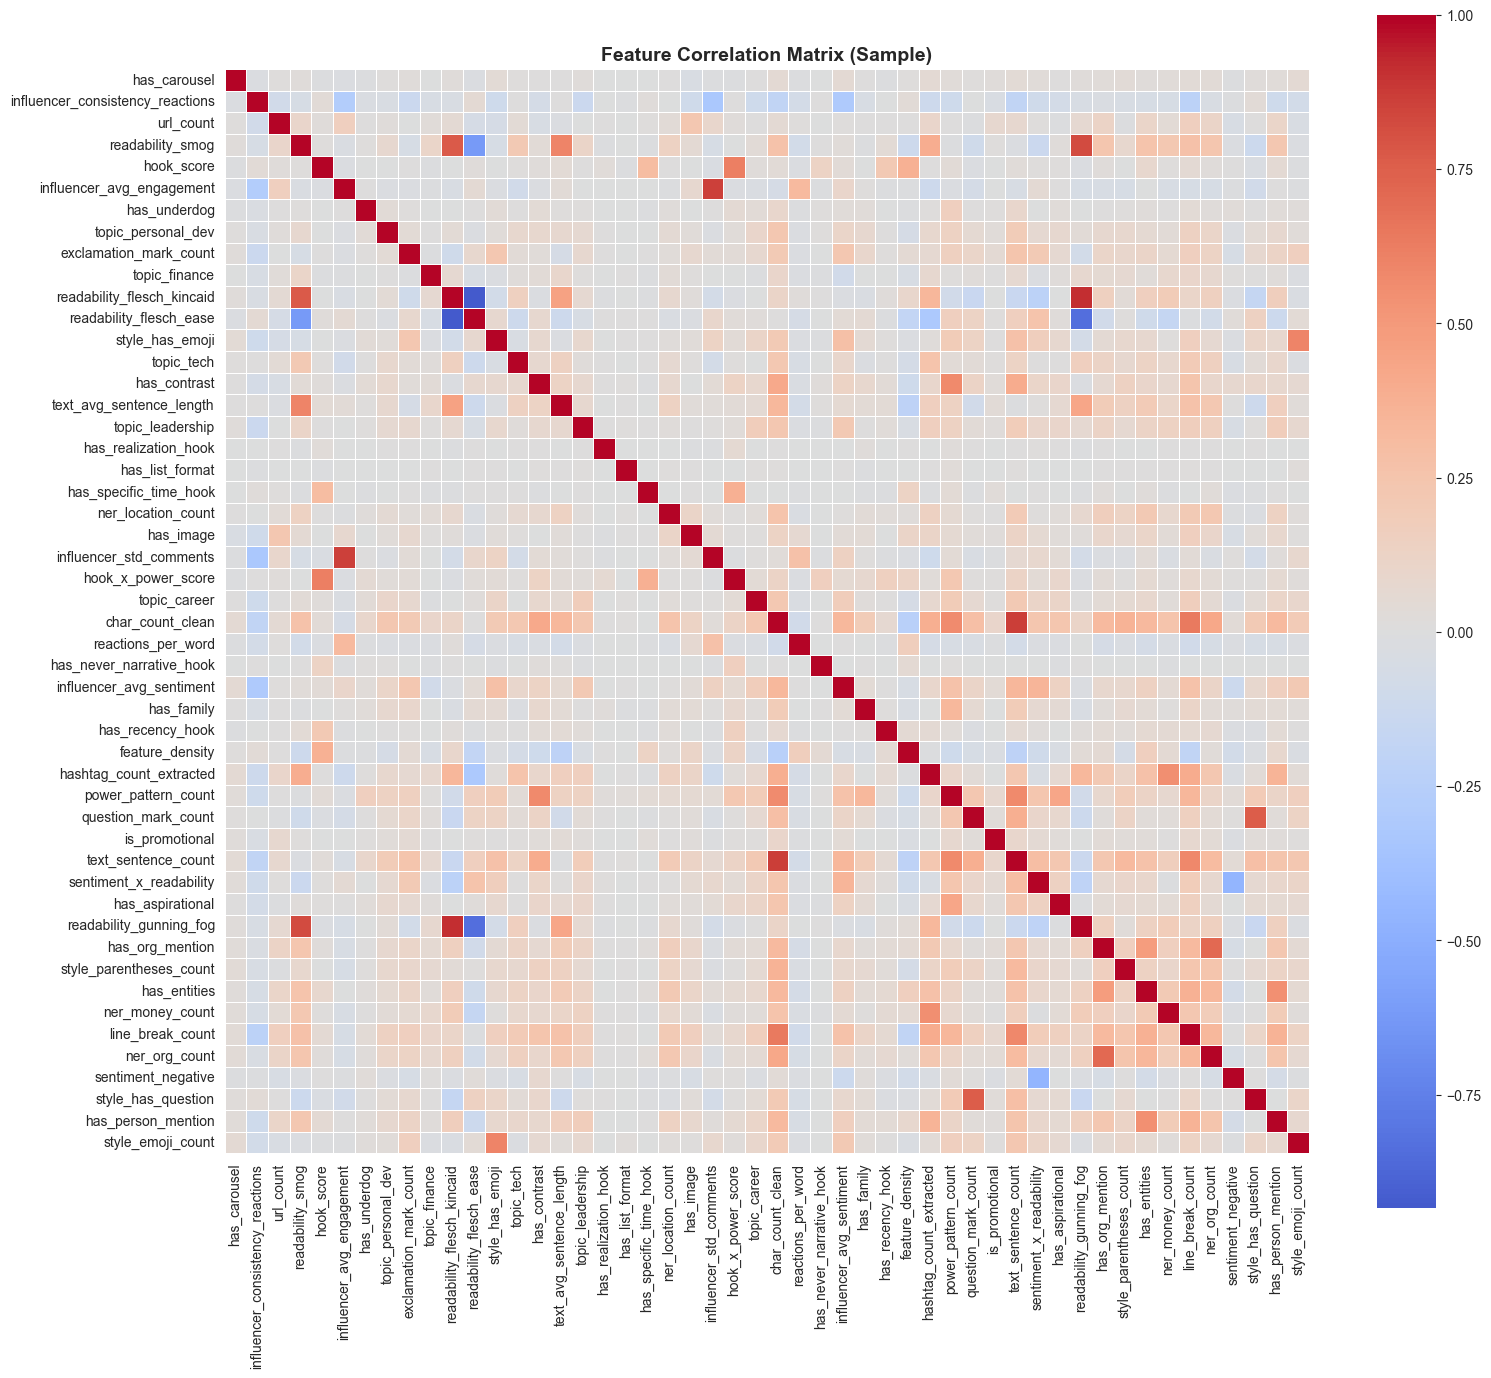


✓ Correlation analysis complete


In [3]:
print("Calculating feature correlations...")

# Select only numeric features for correlation
numeric_features = df[feature_cols].select_dtypes(include=[np.number]).columns.tolist()
corr_matrix = df[numeric_features].corr().abs()

# Find highly correlated pairs (upper triangle)
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation > 0.9
high_corr_features = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.9)]

print(f"\nFeatures with high correlation (r > 0.9): {len(high_corr_features)}")
if high_corr_features:
    print("\nHighly correlated features to review:")
    for feat in high_corr_features[:10]:
        correlated_with = upper_triangle[feat][upper_triangle[feat] > 0.9].index.tolist()
        print(f"  {feat}: {correlated_with}")

# Visualize correlation for a subset
if len(numeric_features) > 50:
    sample_features = np.random.choice(numeric_features, 50, replace=False)
    corr_sample = df[sample_features].corr()
else:
    corr_sample = corr_matrix

plt.figure(figsize=(16, 14))
sns.heatmap(corr_sample, cmap='coolwarm', center=0, square=True, linewidths=0.5)
plt.title('Feature Correlation Matrix (Sample)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\n✓ Correlation analysis complete")

In [4]:
# Remove highly correlated features
# Strategy: For each correlated pair, keep the one with higher correlation to target

features_to_drop = set()
target_corr = df[numeric_features + ['reactions', 'comments']].corr()[['reactions', 'comments']].abs()

for column in upper_triangle.columns:
    correlated_features = upper_triangle[column][upper_triangle[column] > 0.9].index.tolist()
    if correlated_features:
        # Compare correlation with target
        for corr_feat in correlated_features:
            if column in target_corr.index and corr_feat in target_corr.index:
                col_target_corr = target_corr.loc[column].mean()
                corr_feat_target_corr = target_corr.loc[corr_feat].mean()
                
                # Drop the one with lower target correlation
                if col_target_corr < corr_feat_target_corr:
                    features_to_drop.add(column)
                else:
                    features_to_drop.add(corr_feat)

features_to_drop = list(features_to_drop)
print(f"Features to drop due to high correlation: {len(features_to_drop)}")
print(f"Dropped features: {features_to_drop[:10]}...")

# Update feature list
feature_cols_after_corr = [col for col in feature_cols if col not in features_to_drop]
print(f"\nFeatures remaining: {len(feature_cols_after_corr)}")

Features to drop due to high correlation: 28
Dropped features: ['text_syllable_count', 'link_spam_penalty', 'char_count_clean', 'influencer_median_comments', 'readability_flesch_ease', 'promotional_penalty', 'influencer_avg_reactions', 'link_penalty_score', 'total_engagement_elements', 'has_media']...

Features remaining: 116


## 3. Variance Analysis

Remove features with near-zero variance (almost constant values).

Analyzing feature variance...

Features with low variance (< 0.01): 15

Low variance features:
  is_heavy_promo: variance = 0.000000
  has_belief_transformation_hook: variance = 0.000094
  has_realization_hook: variance = 0.000156
  has_never_narrative_hook: variance = 0.000281
  has_list_format: variance = 0.000562
  has_everyone_pattern_hook: variance = 0.000625
  has_contrarian_hook: variance = 0.001093
  has_specific_time_hook: variance = 0.002401
  style_has_bullets: variance = 0.002432
  has_carousel: variance = 0.003426
  has_cta_question: variance = 0.003488
  has_hidden_truth: variance = 0.003705
  sentiment_negative: variance = 0.005157
  has_specific_numbers: variance = 0.007537
  has_underdog: variance = 0.008951


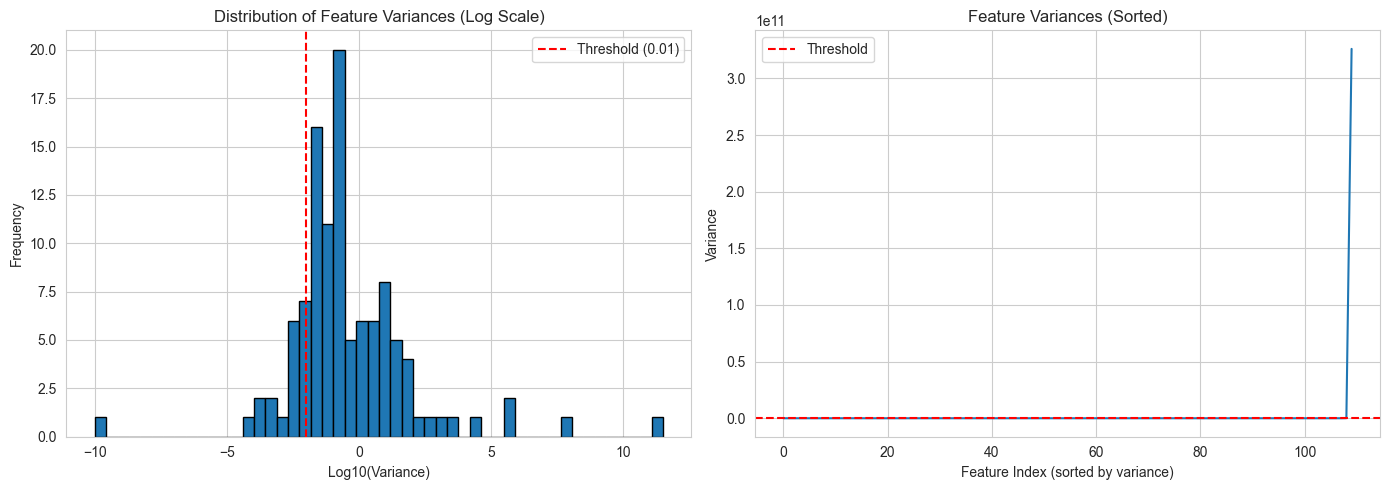


✓ Variance analysis complete


In [5]:
print("Analyzing feature variance...")

# Calculate variance for numeric features
numeric_features_after_corr = [col for col in feature_cols_after_corr if col in numeric_features]
variances = df[numeric_features_after_corr].var().sort_values()

# Identify near-zero variance features (variance < 0.01)
low_variance_features = variances[variances < 0.01].index.tolist()

print(f"\nFeatures with low variance (< 0.01): {len(low_variance_features)}")
if low_variance_features:
    print("\nLow variance features:")
    for feat in low_variance_features[:15]:
        print(f"  {feat}: variance = {variances[feat]:.6f}")

# Visualize variance distribution
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.hist(np.log10(variances + 1e-10), bins=50, edgecolor='black')
plt.xlabel('Log10(Variance)')
plt.ylabel('Frequency')
plt.title('Distribution of Feature Variances (Log Scale)')
plt.axvline(np.log10(0.01), color='red', linestyle='--', label='Threshold (0.01)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(len(variances)), variances.values)
plt.xlabel('Feature Index (sorted by variance)')
plt.ylabel('Variance')
plt.title('Feature Variances (Sorted)')
plt.axhline(0.01, color='red', linestyle='--', label='Threshold')
plt.legend()
plt.tight_layout()
plt.show()

print(f"\n✓ Variance analysis complete")

In [6]:
# Remove low variance features
feature_cols_after_variance = [col for col in feature_cols_after_corr if col not in low_variance_features]
print(f"Features remaining after variance filter: {len(feature_cols_after_variance)}")

Features remaining after variance filter: 101


## 4. Feature Importance Analysis

Use Random Forest to identify important features for predicting reactions and comments.

In [7]:
print("Training Random Forest for feature importance...")

# Prepare data
X = df[feature_cols_after_variance].select_dtypes(include=[np.number]).fillna(0)
y_reactions = df['reactions'].fillna(0)
y_comments = df['comments'].fillna(0)

print(f"\nTraining set: {X.shape[0]:,} samples × {X.shape[1]} features")
print("Training models (this may take 2-3 minutes)...")

# Train Random Forest for reactions
rf_reactions = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_reactions.fit(X, y_reactions)

# Train Random Forest for comments
rf_comments = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_comments.fit(X, y_comments)

# Get feature importances
importance_reactions = pd.DataFrame({
    'feature': X.columns,
    'importance_reactions': rf_reactions.feature_importances_
}).sort_values('importance_reactions', ascending=False)

importance_comments = pd.DataFrame({
    'feature': X.columns,
    'importance_comments': rf_comments.feature_importances_
}).sort_values('importance_comments', ascending=False)

# Merge importances
feature_importance = importance_reactions.merge(importance_comments, on='feature')
feature_importance['avg_importance'] = (feature_importance['importance_reactions'] + 
                                         feature_importance['importance_comments']) / 2
feature_importance = feature_importance.sort_values('avg_importance', ascending=False)

print("\n✓ Random Forest training complete")
print(f"\nTop 20 most important features:")
print(feature_importance.head(20).to_string(index=False))

Training Random Forest for feature importance...

Training set: 31,996 samples × 95 features
Training models (this may take 2-3 minutes)...

✓ Random Forest training complete

Top 20 most important features:
                         feature  importance_reactions  importance_comments  avg_importance
         reactions_per_sentiment              0.810985             0.375061        0.593023
               comments_per_word              0.000699             0.361373        0.181036
             word_count_original              0.000567             0.126497        0.063532
     reactions_vs_influencer_avg              0.095363             0.002198        0.048780
      comments_vs_influencer_avg              0.002828             0.090027        0.046427
       influencer_avg_engagement              0.016011             0.018194        0.017102
              reactions_per_word              0.030373             0.000712        0.015542
              sentiment_compound              0.020942  

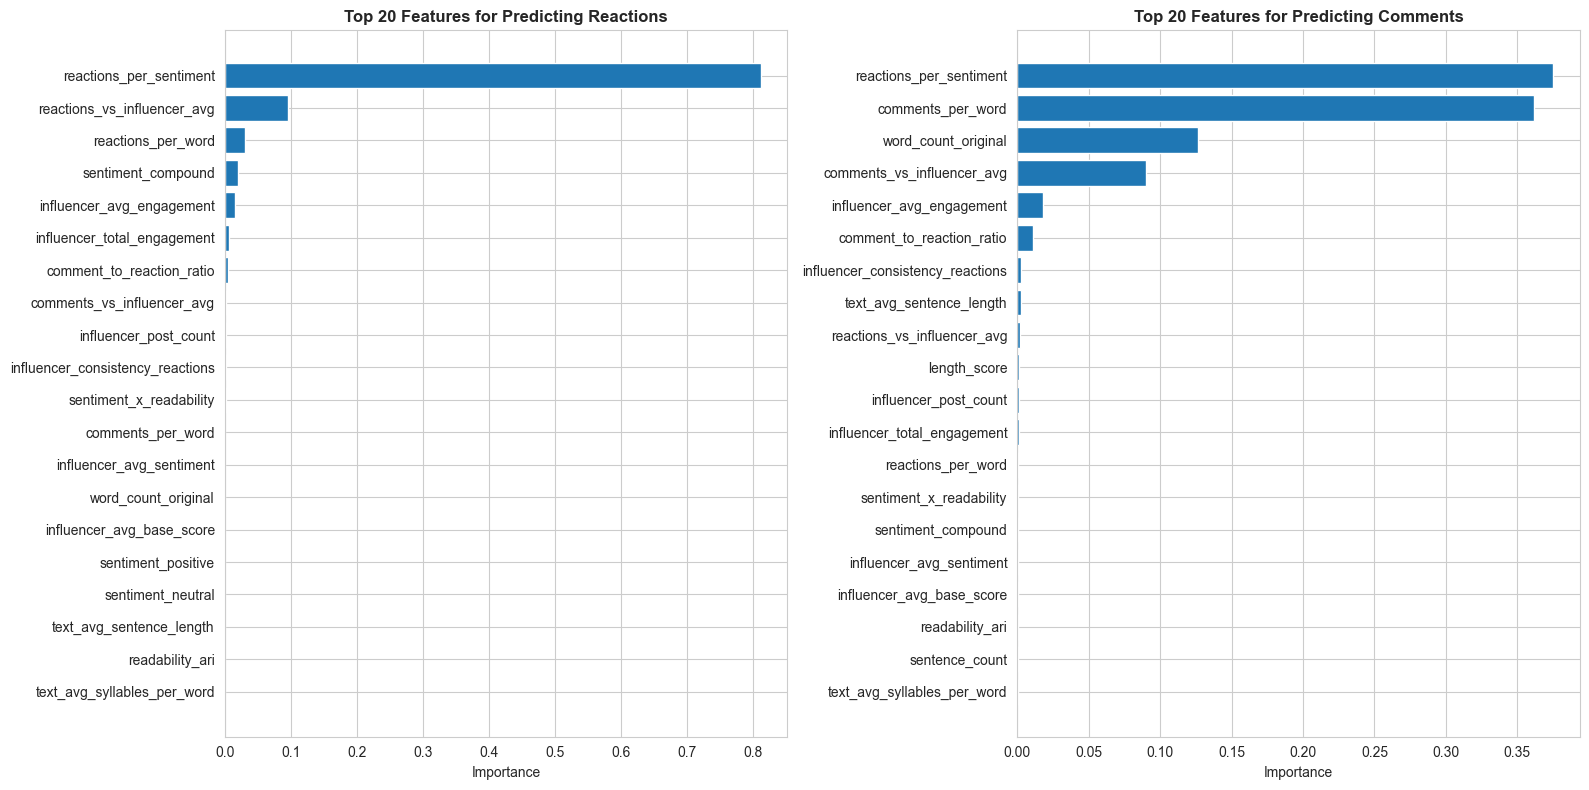

In [8]:
# Visualize feature importance
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Top 20 for reactions
top20_reactions = feature_importance.nlargest(20, 'importance_reactions')
axes[0].barh(range(20), top20_reactions['importance_reactions'].values)
axes[0].set_yticks(range(20))
axes[0].set_yticklabels(top20_reactions['feature'].values)
axes[0].set_xlabel('Importance')
axes[0].set_title('Top 20 Features for Predicting Reactions', fontweight='bold')
axes[0].invert_yaxis()

# Top 20 for comments
top20_comments = feature_importance.nlargest(20, 'importance_comments')
axes[1].barh(range(20), top20_comments['importance_comments'].values)
axes[1].set_yticks(range(20))
axes[1].set_yticklabels(top20_comments['feature'].values)
axes[1].set_xlabel('Importance')
axes[1].set_title('Top 20 Features for Predicting Comments', fontweight='bold')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

## 5. Final Feature Selection

Select top 90 features based on average importance.

In [9]:
# Select top features
n_features_to_select = 90
selected_features = feature_importance.nlargest(n_features_to_select, 'avg_importance')['feature'].tolist()

print(f"Selected {len(selected_features)} features based on importance")
print(f"\nCumulative importance: {feature_importance.nlargest(n_features_to_select, 'avg_importance')['avg_importance'].sum():.3f}")

# Add back essential metadata columns
metadata_cols = ['name', 'slno', 'content', 'reactions', 'comments', 'time_spent', 'location', 'followers']
final_columns = metadata_cols + selected_features

# Create final dataset
df_selected = df[final_columns].copy()

print(f"\nFinal dataset shape: {df_selected.shape[0]:,} rows × {df_selected.shape[1]} columns")
print(f"  - Metadata columns: {len(metadata_cols)}")
print(f"  - Selected features: {len(selected_features)}")

# Feature selection summary
print("\n" + "="*60)
print("FEATURE SELECTION SUMMARY")
print("="*60)
print(f"Original features: 127")
print(f"After correlation filter: {len(feature_cols_after_corr)}")
print(f"After variance filter: {len(feature_cols_after_variance)}")
print(f"After importance ranking: {len(selected_features)}")
print(f"\n✓ Feature selection complete!")

Selected 90 features based on importance

Cumulative importance: 1.000

Final dataset shape: 31,996 rows × 98 columns
  - Metadata columns: 8
  - Selected features: 90

FEATURE SELECTION SUMMARY
Original features: 127
After correlation filter: 116
After variance filter: 101
After importance ranking: 90

✓ Feature selection complete!



Selected features by category:
  base_formula: 12
  nlp: 31
  topic: 7
  influencer: 6
  derived: 13


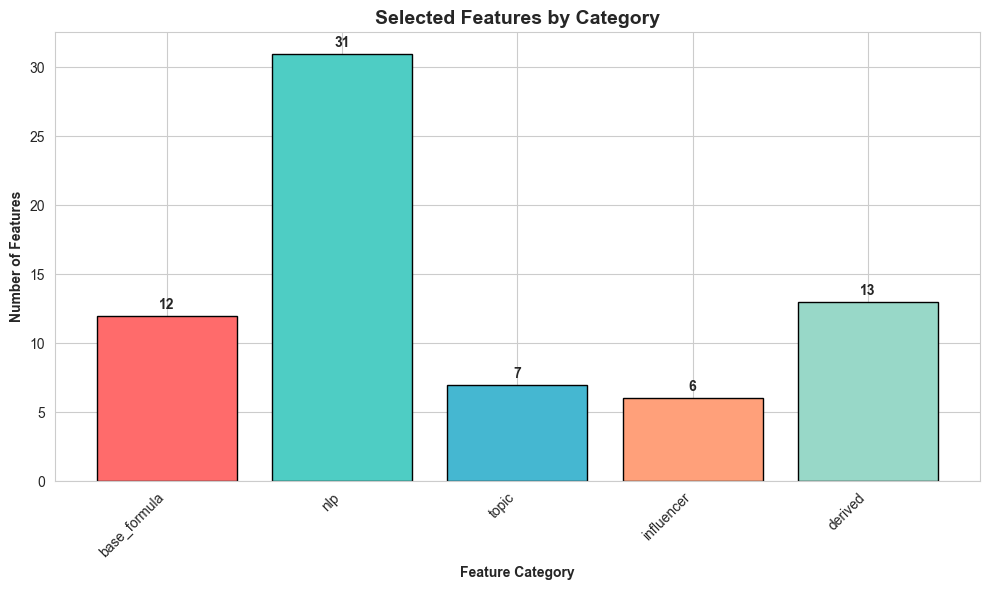

In [10]:
# Categorize selected features
selected_by_category = {
    'base_formula': [f for f in selected_features if any(x in f for x in ['length_', 'hook_', 'power_', 'media_', 'link_', 'pattern_', 'promotional_', 'base_score'])],
    'nlp': [f for f in selected_features if any(x in f for x in ['sentiment_', 'ner_', 'readability_', 'text_', 'style_'])],
    'topic': [f for f in selected_features if f.startswith('topic_')],
    'influencer': [f for f in selected_features if f.startswith('influencer_')],
    'derived': [f for f in selected_features if any(x in f for x in ['_ratio', '_vs_', '_per_', '_x_', 'feature_density'])]
}

print("\nSelected features by category:")
for category, features in selected_by_category.items():
    print(f"  {category}: {len(features)}")

# Visualize category distribution
plt.figure(figsize=(10, 6))
categories = list(selected_by_category.keys())
counts = [len(selected_by_category[cat]) for cat in categories]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8']

plt.bar(categories, counts, color=colors, edgecolor='black')
plt.xlabel('Feature Category', fontweight='bold')
plt.ylabel('Number of Features', fontweight='bold')
plt.title('Selected Features by Category', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
for i, v in enumerate(counts):
    plt.text(i, v + 0.5, str(v), ha='center', fontweight='bold')
plt.tight_layout()
plt.show()

## 6. Save Results

In [11]:
# Save selected features dataset
df_selected.to_csv(OUTPUT_FILE, index=False)
print(f"✓ Selected features dataset saved: {OUTPUT_FILE}")
print(f"  Size: {df_selected.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Save feature names and importance scores
selection_metadata = {
    'n_features_selected': len(selected_features),
    'selected_features': selected_features,
    'features_by_category': selected_by_category,
    'feature_importance': feature_importance.to_dict('records'),
    'dropped_high_correlation': features_to_drop,
    'dropped_low_variance': low_variance_features
}

with open(SELECTED_FEATURES_FILE, 'w') as f:
    json.dump(selection_metadata, f, indent=2)
print(f"✓ Feature selection metadata saved: {SELECTED_FEATURES_FILE}")

print("\n" + "="*60)
print("SUCCESS: Feature selection complete!")
print("="*60)
print(f"\nNext step: Exploratory Feature Analysis")

✓ Selected features dataset saved: ../data/selected_features_data.csv
  Size: 51.94 MB
✓ Feature selection metadata saved: ../data/selected_features.json

SUCCESS: Feature selection complete!

Next step: Exploratory Feature Analysis
